The KU-HAR dataset contains data in three different formats. The first format includes raw data stored in separate files for each activity. The second format consists of cleaned and trimmed versions of the raw data. The third format includes data that has been segmented into non-overlapping 3-second windows at 100 Hz. Since this project uses 3-second non-overlapping segments, the segmented version of the KU-HAR dataset will be used.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay

os.makedirs("models", exist_ok=True)
data = pd.read_csv('dataset/KU-HAR/3.Time_domain_subsamples/KU-HAR_time_domain_subsamples_20750x300.csv', header=None)
#AŞAĞIDAKİ YORUM SATIRINI AÇIP ÜSTTEKİNİ YORUMA ALIRSANIZ YENİDEN TRİN TEST ETMEK GEREKİR. ÜSTTEKİ BÜTÜN VERİ SETİ. ALTTAKI SUBSET
#data = pd.read_csv('dataset/KU-HAR/3.Time_domain_subsamples/KU-HAR_time_domain_subsamples_subset.csv', header=None)
activity_labels = [
    'Stand',
    'Sit',
    'Talk-sit',
    'Talk-stand',
    'Stand-sit',
    'Lay',
    'Lay-stand',
    'Pick',
    'Jump',
    'Push-up',
    'Sit-up',
    'Walk',
    'Walk-backward',
    'Walk-circle',
    'Run',
    'Stair-up',
    'Stair-down',
    'Table-tennis'
]
#print(data.head())
sensor_data = data.iloc[:, :1800].to_numpy()
labels = data.iloc[:,1800].to_numpy()
#(sensor_data.shape[0])

In [3]:
sensor_index = [
    (0, 300),    #acc_x
    (300, 600),   #acc_y
    (600, 900),   #acc_z
    (900, 1200),  #gyro_x
    (1200, 1500), #gyro_y
    (1500, 1800)  #gyro_z
]

feature_list = []

for i in range(sensor_data.shape[0]):
    segment_row = sensor_data[i]
    segment_features = []
    for j in range(len(sensor_index)):
        start, end = sensor_index[j]
        data = segment_row[start:end]

        segment_features.append(np.mean(data))
        segment_features.append(np.min(data))
        segment_features.append(np.max(data))
        segment_features.append(np.std(data))
        segment_features.append(np.median(data))
        segment_features.append(stats.median_abs_deviation(data)) # mad
        segment_features.append(np.sqrt(np.mean(data**2))) # rms
        segment_features.append(np.sum(data**2)) # enerji
        
        hist, _ = np.histogram(data, bins=10, density=True)
        segment_features.append(stats.entropy(hist))  # entropi

    feature_list.append(segment_features)

feature_extraction = pd.DataFrame(feature_list)
feature_names = ['mean', 'min', 'max', 'std', 'median', 'mad', 'rms', 'energy', 'entropy']
axis_name = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

column_names = [f'{axis}_{feat}' for axis in axis_name for feat in feature_names]
feature_extraction.columns = column_names
y_labels = labels

# print(feature_extraction.shape)
# print(feature_extraction.head())
#print(y_labels)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(feature_extraction, y_labels, test_size=0.3, random_state=17,stratify =y_labels)

#StandardScaler (SVM, KNN, MLP)
scaler = StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

joblib.dump(scaler, 'models/kuhar/standard_scaler.joblib')

#PCA
pca = PCA(n_components=0.95, random_state=17)
x_train_pca=pca.fit_transform(x_train)
x_test_pca=pca.transform(x_test)

In [5]:
def model_train(model, x_train, y_train, x_test, y_test, name, pca):
    print(f"Model: {name} {pca}")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
   
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=activity_labels, zero_division=0))
    print("Confusion Matrix:")
    figure, axes = plt.subplots(figsize=(15,15))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=activity_labels,
        cmap='Greens',  
        xticks_rotation='horizontal', 
        ax=axes 
    )
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    joblib.dump(model, f'models/kuhar/{name}_{pca.replace(" ", "_")}_kuhar.joblib')

Without PCA

Model: SVM Without PCA
Accuracy: 0.3767

               precision    recall  f1-score   support

        Stand       0.23      0.24      0.23       566
          Sit       0.32      0.35      0.33       562
     Talk-sit       0.29      0.29      0.29       539
   Talk-stand       0.51      0.71      0.59       560
    Stand-sit       0.36      0.57      0.44       653
          Lay       0.39      0.40      0.39       544
    Lay-stand       0.30      0.27      0.29       529
         Pick       0.32      0.33      0.32       400
         Jump       0.57      0.72      0.64       200
      Push-up       0.71      0.42      0.52       144
       Sit-up       0.48      0.26      0.34       301
         Walk       0.42      0.62      0.50       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       0.73      0.35      0.48       179
     Stair-up       0.33      0.28      0.30       239
   Stair-down       0.3

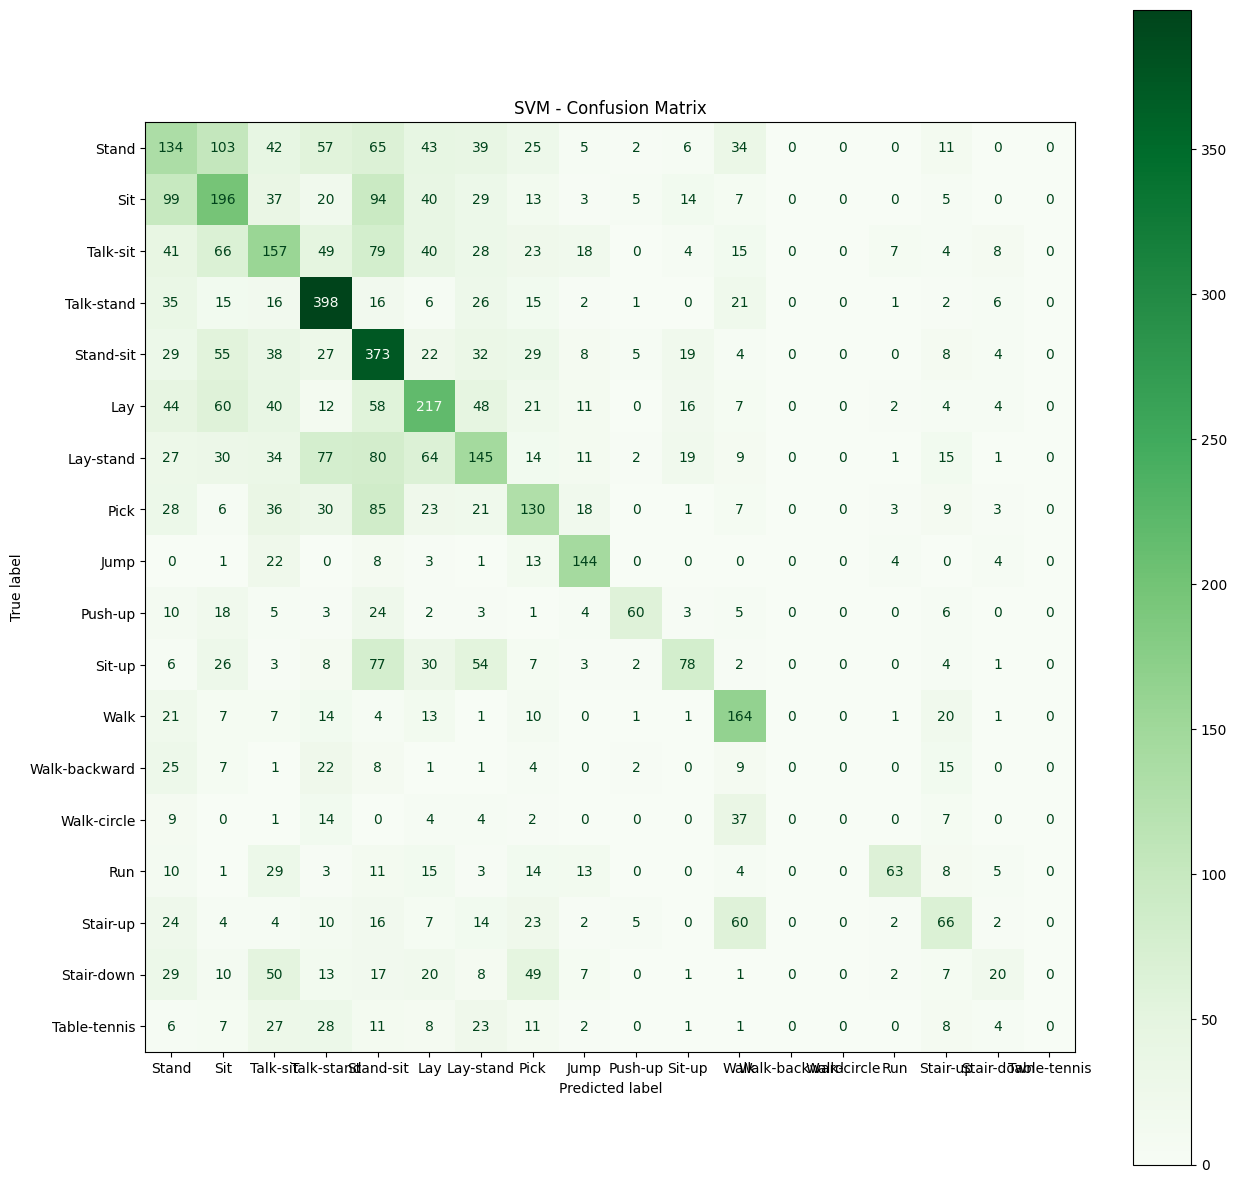

Model: Random Forest Without PCA
Accuracy: 0.9383

               precision    recall  f1-score   support

        Stand       0.91      0.92      0.91       566
          Sit       0.93      0.93      0.93       562
     Talk-sit       0.91      0.94      0.92       539
   Talk-stand       0.93      0.97      0.95       560
    Stand-sit       0.95      0.98      0.96       653
          Lay       0.97      0.94      0.95       544
    Lay-stand       0.96      0.97      0.97       529
         Pick       0.90      0.93      0.91       400
         Jump       0.98      0.98      0.98       200
      Push-up       1.00      0.92      0.96       144
       Sit-up       0.97      0.89      0.93       301
         Walk       0.93      0.89      0.91       265
Walk-backward       0.92      0.74      0.82        95
  Walk-circle       0.91      0.92      0.92        78
          Run       0.98      0.98      0.98       179
     Stair-up       0.90      0.91      0.91       239
   Stair-down

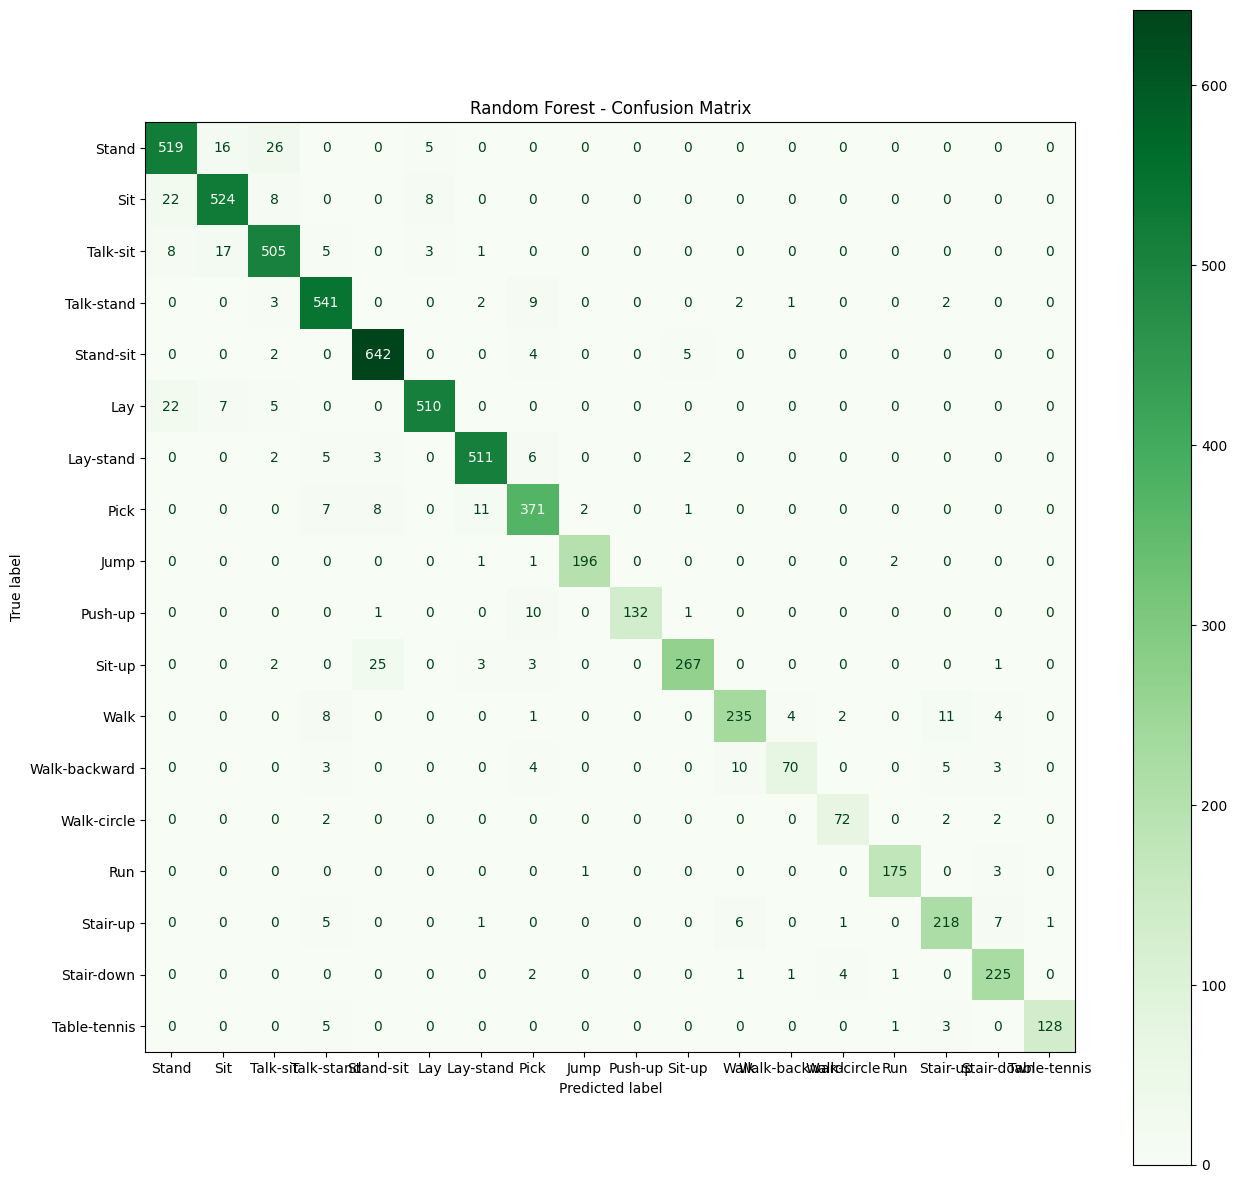

Model: KNN Without PCA
Accuracy: 0.3184

               precision    recall  f1-score   support

        Stand       0.16      0.30      0.21       566
          Sit       0.23      0.30      0.26       562
     Talk-sit       0.22      0.22      0.22       539
   Talk-stand       0.51      0.60      0.55       560
    Stand-sit       0.32      0.40      0.36       653
          Lay       0.35      0.31      0.33       544
    Lay-stand       0.24      0.17      0.20       529
         Pick       0.30      0.21      0.25       400
         Jump       0.56      0.63      0.59       200
      Push-up       0.61      0.40      0.49       144
       Sit-up       0.34      0.20      0.25       301
         Walk       0.53      0.54      0.54       265
Walk-backward       0.11      0.04      0.06        95
  Walk-circle       0.21      0.09      0.12        78
          Run       0.60      0.35      0.44       179
     Stair-up       0.34      0.22      0.27       239
   Stair-down       0.3

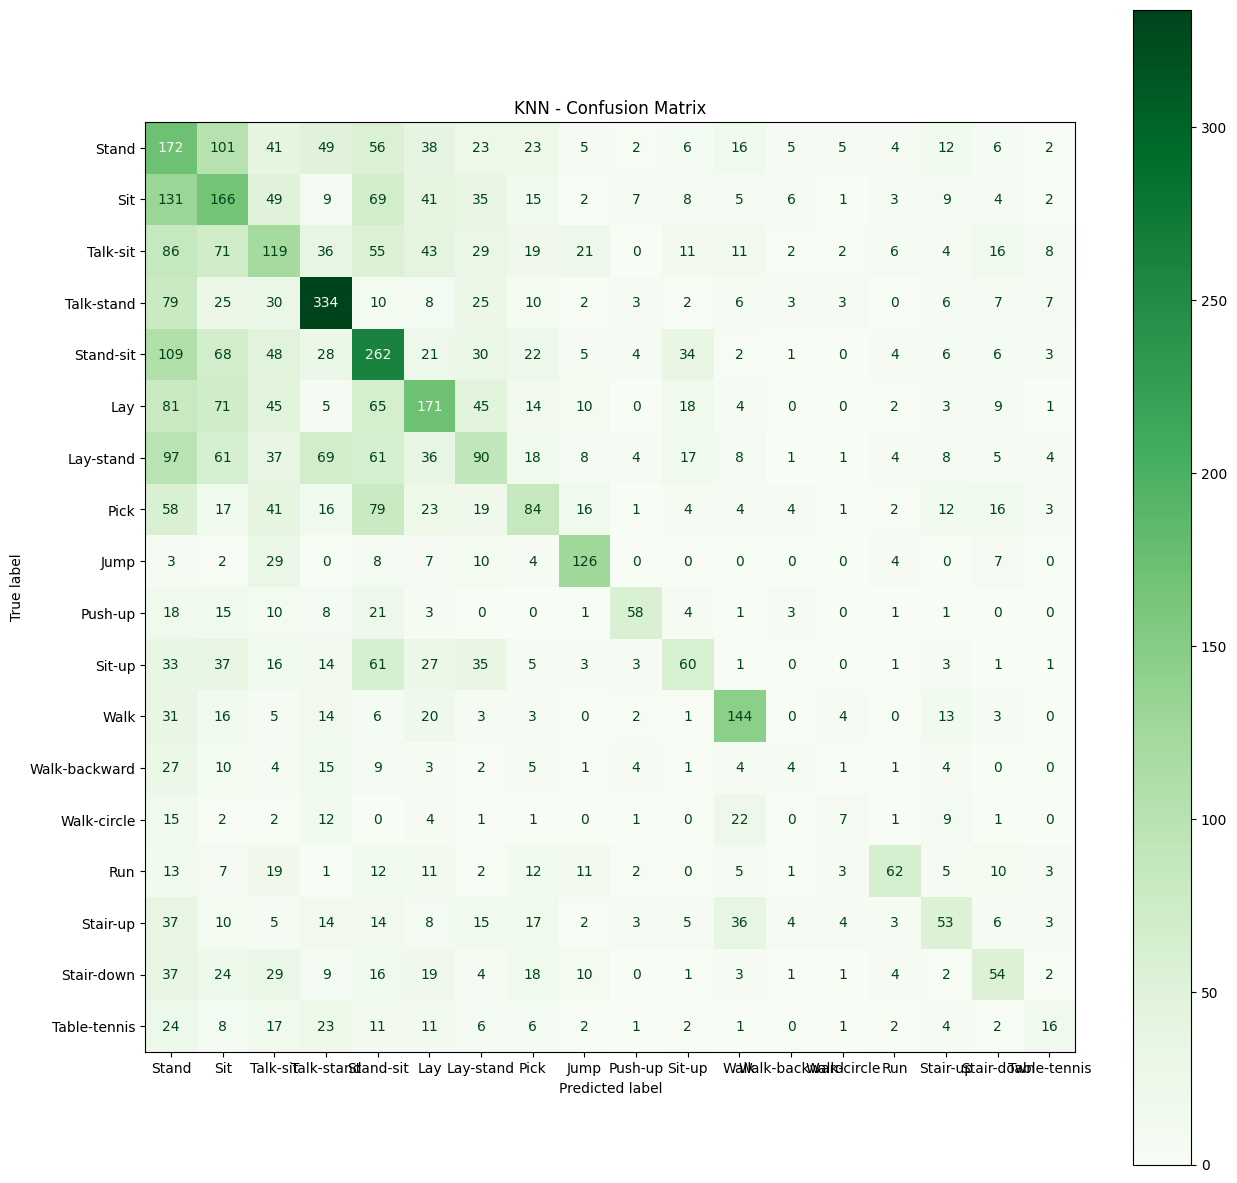

Model: XGBoost Without PCA
Accuracy: 0.9512

               precision    recall  f1-score   support

        Stand       0.94      0.92      0.93       566
          Sit       0.94      0.94      0.94       562
     Talk-sit       0.93      0.94      0.93       539
   Talk-stand       0.95      0.98      0.97       560
    Stand-sit       0.97      0.98      0.97       653
          Lay       0.97      0.96      0.97       544
    Lay-stand       0.96      0.97      0.97       529
         Pick       0.92      0.95      0.94       400
         Jump       0.98      0.98      0.98       200
      Push-up       0.99      0.92      0.95       144
       Sit-up       0.96      0.93      0.94       301
         Walk       0.93      0.93      0.93       265
Walk-backward       0.95      0.78      0.86        95
  Walk-circle       0.90      0.91      0.90        78
          Run       0.99      0.98      0.99       179
     Stair-up       0.95      0.95      0.95       239
   Stair-down      

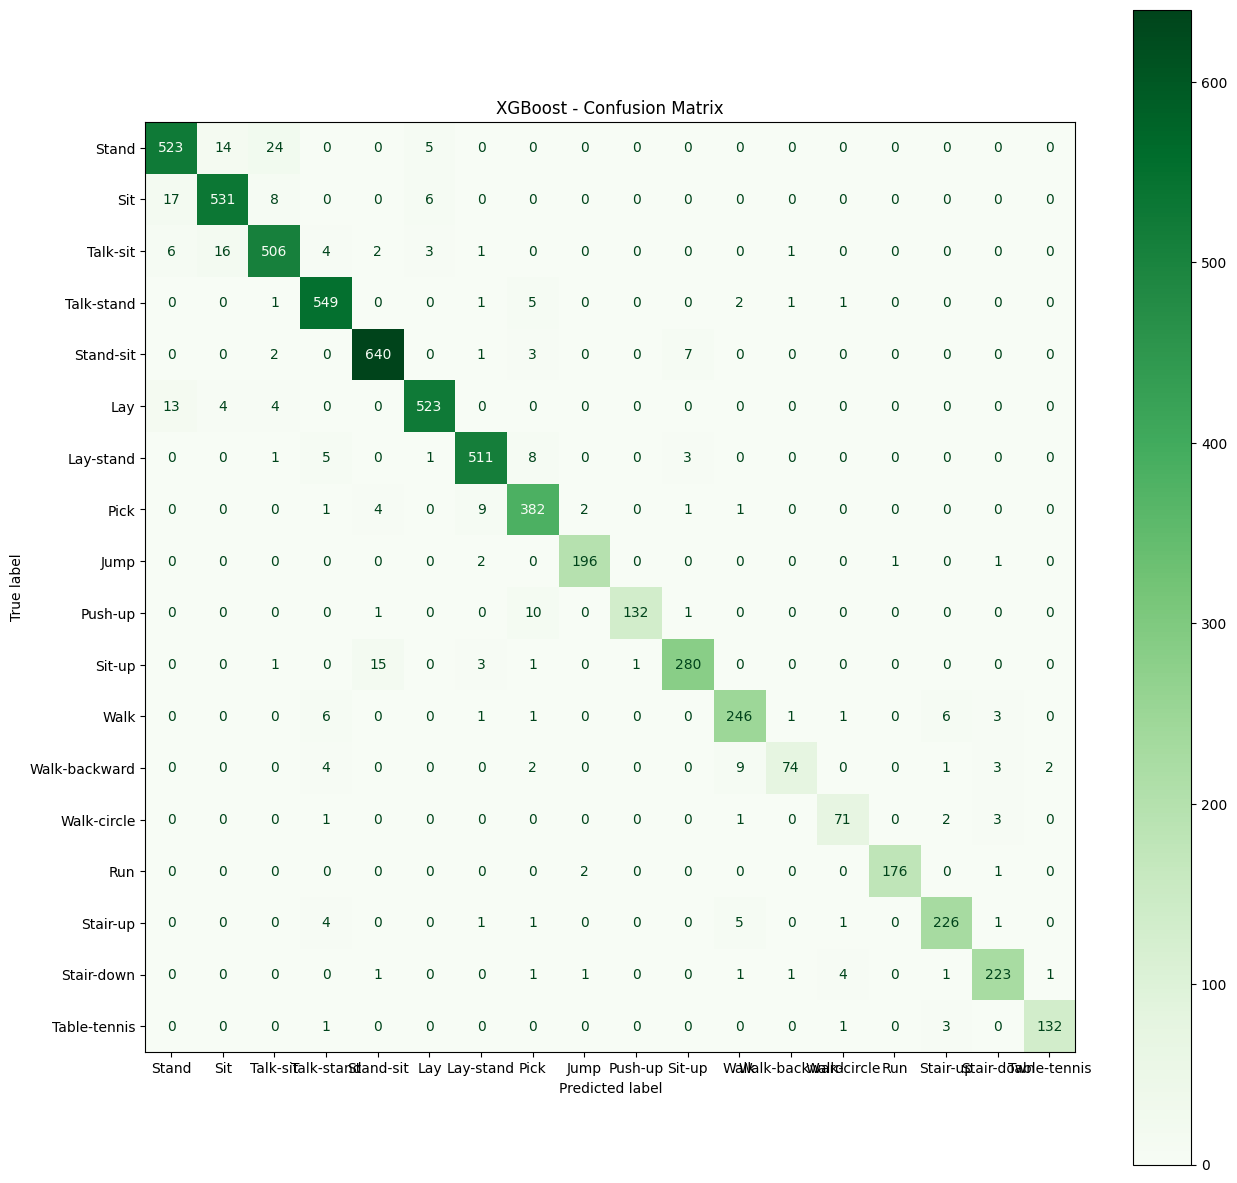

Model: MLP Without PCA


c:\Users\aylin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.6533

               precision    recall  f1-score   support

        Stand       0.45      0.47      0.46       566
          Sit       0.45      0.46      0.46       562
     Talk-sit       0.52      0.52      0.52       539
   Talk-stand       0.81      0.86      0.83       560
    Stand-sit       0.76      0.86      0.81       653
          Lay       0.58      0.57      0.57       544
    Lay-stand       0.74      0.69      0.72       529
         Pick       0.72      0.72      0.72       400
         Jump       0.96      0.92      0.94       200
      Push-up       0.68      0.56      0.61       144
       Sit-up       0.76      0.68      0.72       301
         Walk       0.63      0.73      0.67       265
Walk-backward       0.46      0.28      0.35        95
  Walk-circle       0.08      0.01      0.02        78
          Run       0.93      0.93      0.93       179
     Stair-up       0.58      0.51      0.54       239
   Stair-down       0.64      0.82      0.72  

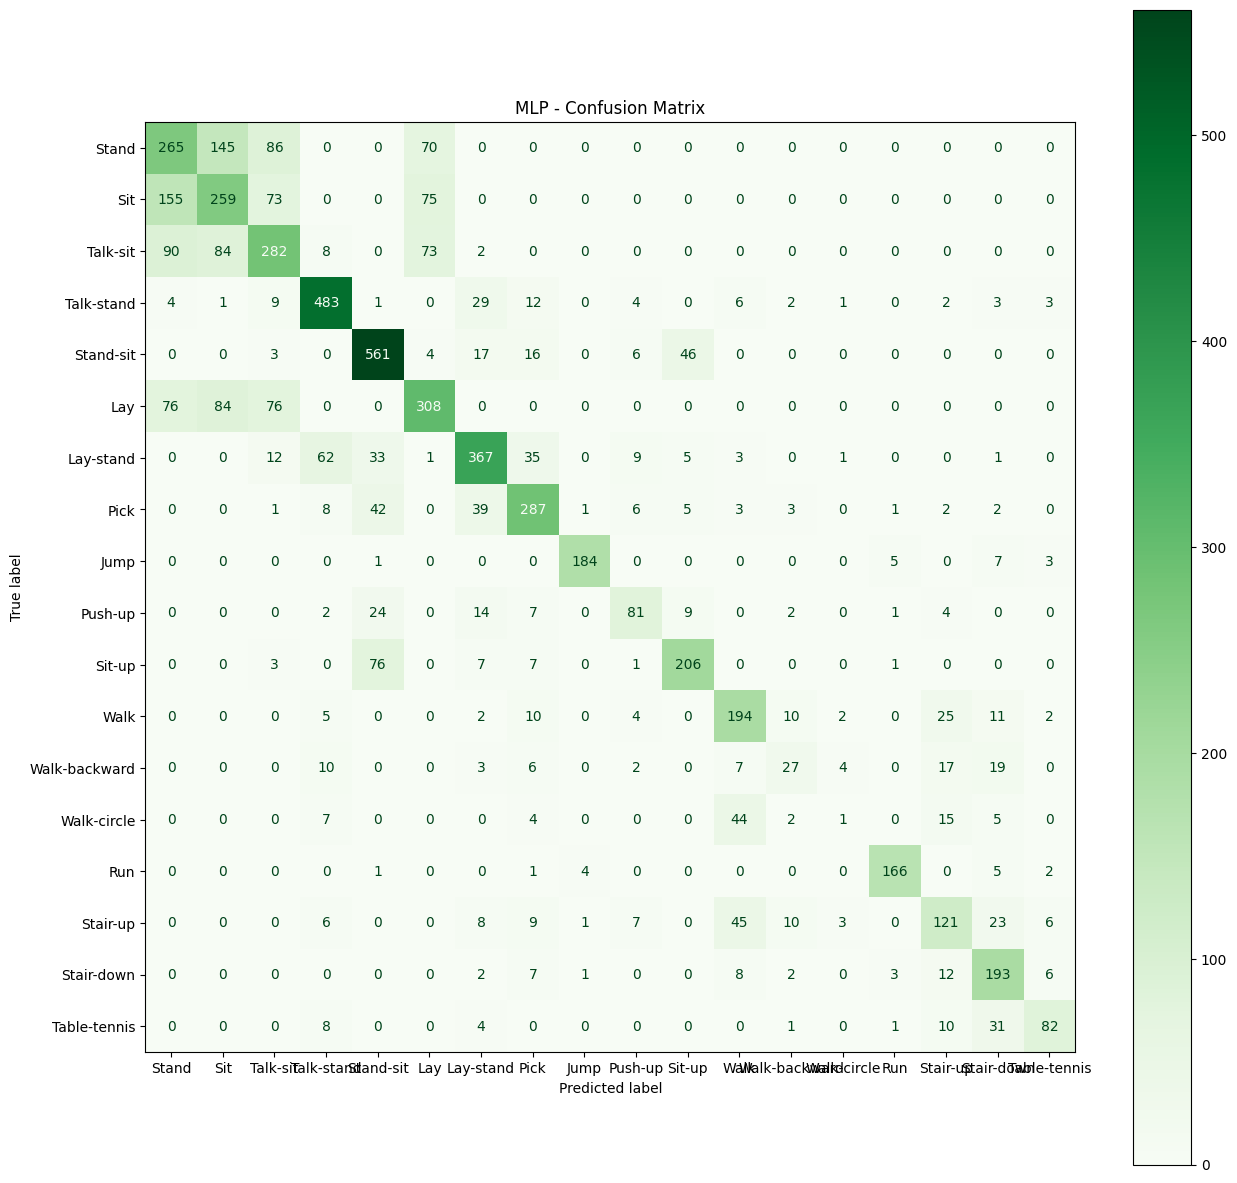

Model: Naive Bayes Without PCA
Accuracy: 0.1099

               precision    recall  f1-score   support

        Stand       0.00      0.00      0.00       566
          Sit       0.00      0.00      0.00       562
     Talk-sit       0.00      0.00      0.00       539
   Talk-stand       0.00      0.00      0.00       560
    Stand-sit       0.11      1.00      0.19       653
          Lay       0.00      0.00      0.00       544
    Lay-stand       0.00      0.00      0.00       529
         Pick       0.00      0.00      0.00       400
         Jump       0.00      0.00      0.00       200
      Push-up       0.00      0.00      0.00       144
       Sit-up       0.00      0.00      0.00       301
         Walk       0.00      0.00      0.00       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       1.00      0.17      0.30       179
     Stair-up       0.00      0.00      0.00       239
   Stair-down  

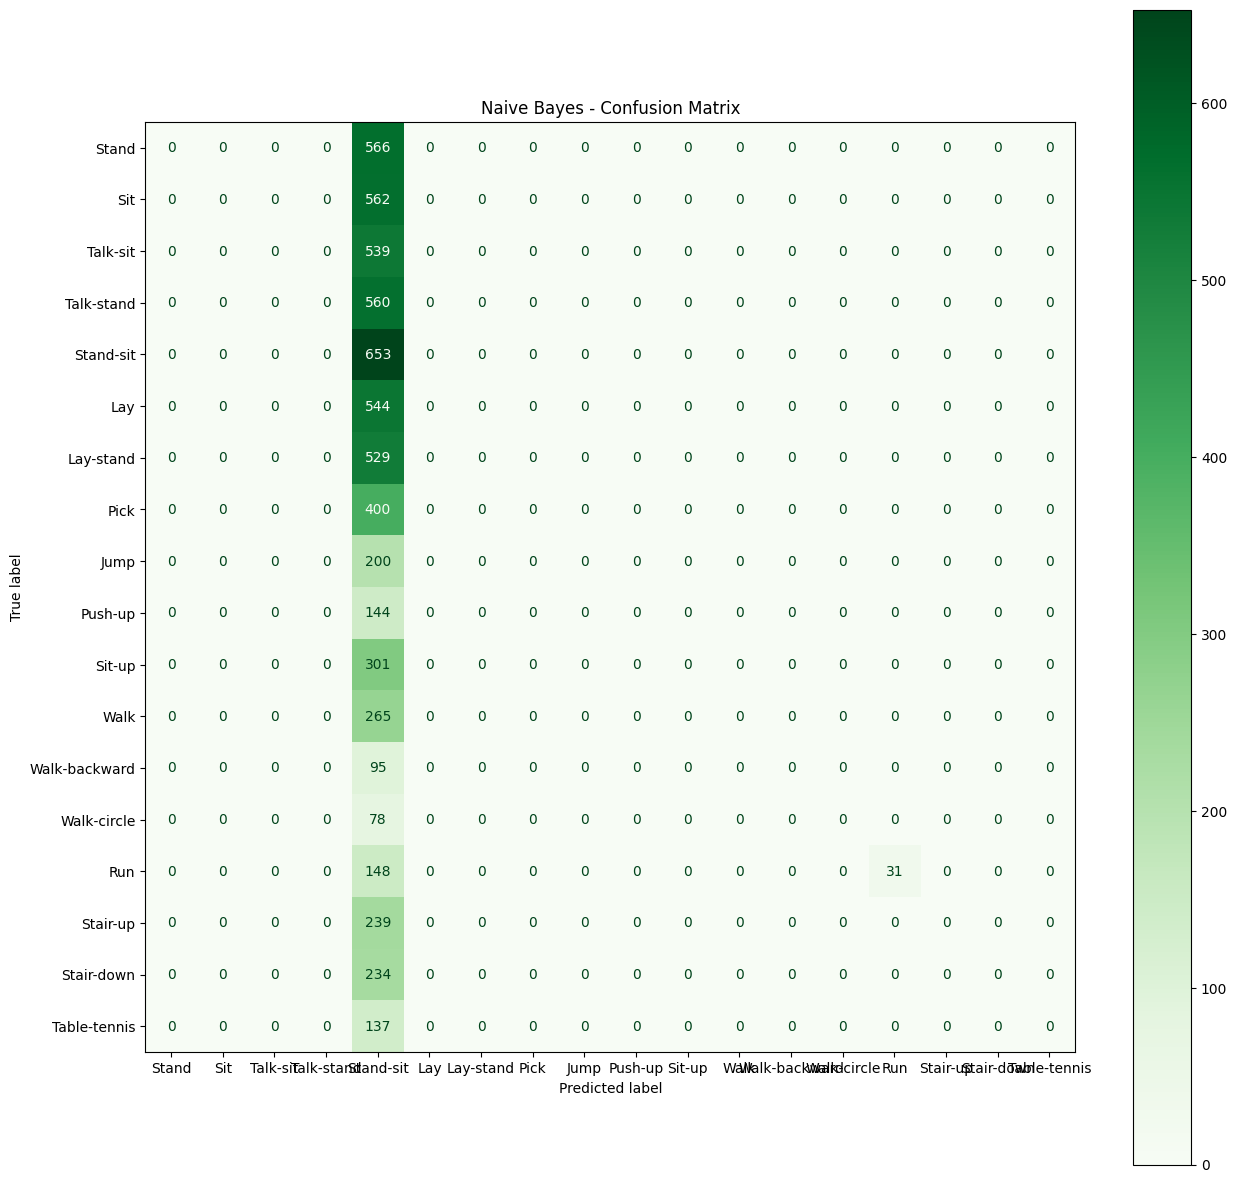

In [6]:
models_without_pca = [
    ("SVM", SVC(random_state=17), x_train_scaled, x_test_scaled),
    ("Random Forest", RandomForestClassifier(random_state=17), x_train, x_test),
    ("KNN", KNeighborsClassifier(), x_train_scaled, x_test_scaled),
    ("XGBoost", XGBClassifier(verbosity=0, use_label_encoder=False,random_state=17), x_train, x_test),
    ("MLP", MLPClassifier(max_iter=300,random_state=17), x_train_scaled, x_test_scaled),
    ("Naive Bayes", GaussianNB(), x_train, x_test)
]

for name, model, xTrain, xTest in models_without_pca:
    model_train(model, xTrain, y_train, xTest, y_test, name, pca='Without PCA')

WİTH PCA

Model: SVM With PCA
Accuracy: 0.2855

               precision    recall  f1-score   support

        Stand       0.20      0.30      0.24       566
          Sit       0.25      0.29      0.27       562
     Talk-sit       0.20      0.27      0.23       539
   Talk-stand       0.43      0.66      0.52       560
    Stand-sit       0.26      0.56      0.35       653
          Lay       0.22      0.08      0.12       544
    Lay-stand       0.24      0.27      0.25       529
         Pick       0.15      0.04      0.07       400
         Jump       0.41      0.71      0.52       200
      Push-up       0.72      0.33      0.45       144
       Sit-up       0.36      0.10      0.16       301
         Walk       0.36      0.36      0.36       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       1.00      0.22      0.37       179
     Stair-up       0.00      0.00      0.00       239
   Stair-down       0.00  

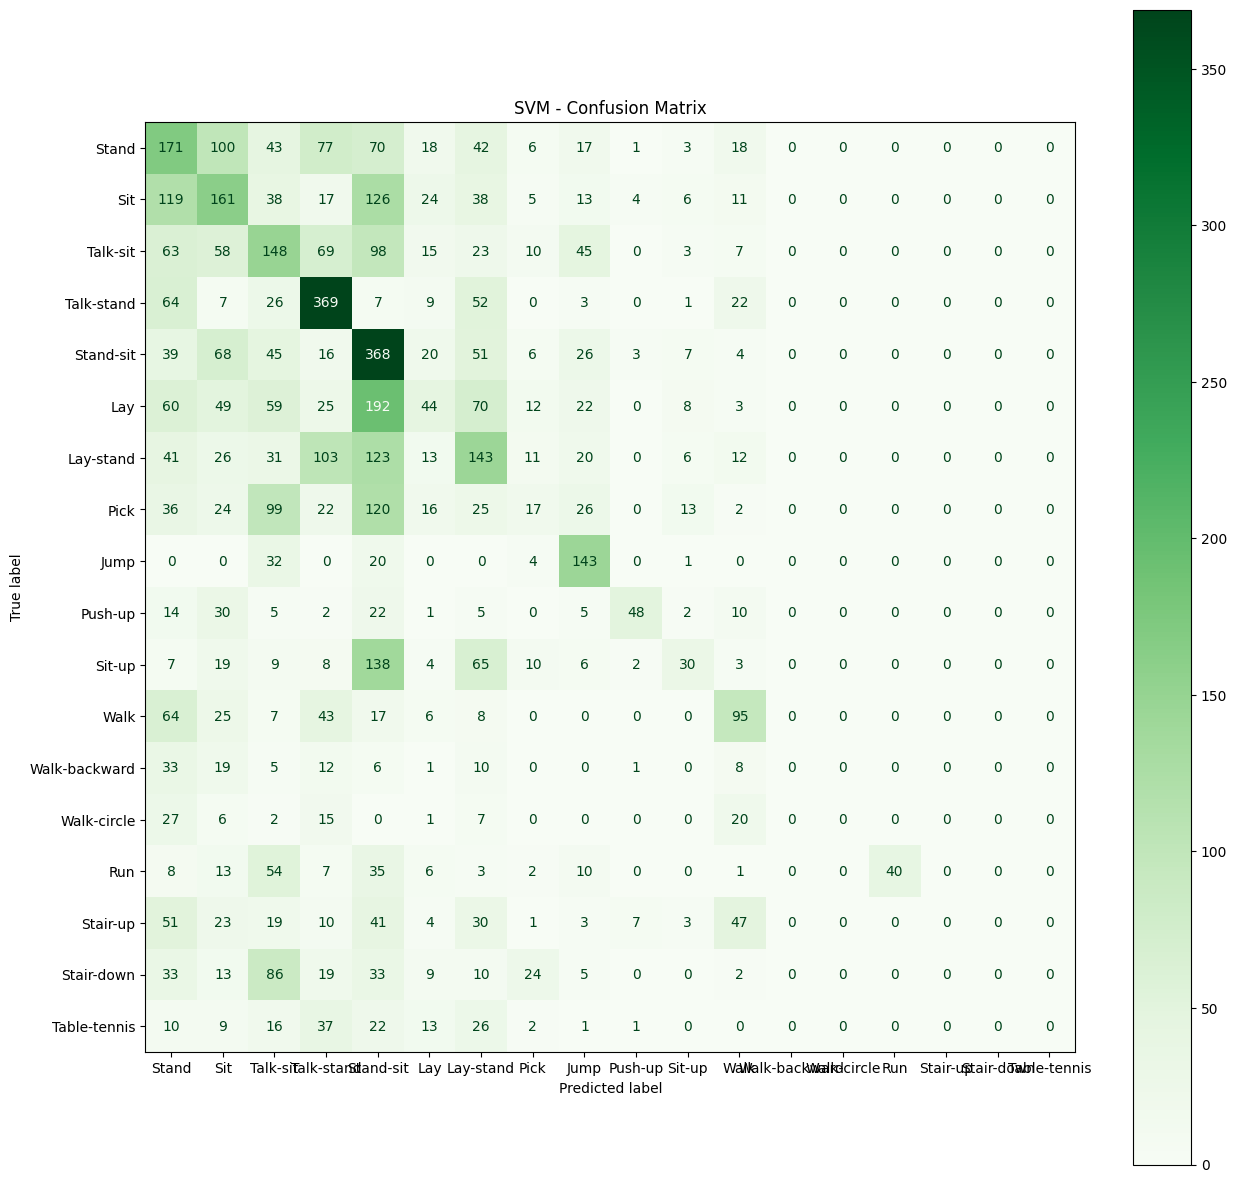

Model: Random Forest With PCA
Accuracy: 0.2469

               precision    recall  f1-score   support

        Stand       0.00      0.00      0.00       566
          Sit       0.00      0.00      0.00       562
     Talk-sit       0.00      0.00      0.00       539
   Talk-stand       0.00      0.00      0.00       560
    Stand-sit       0.14      0.92      0.25       653
          Lay       0.00      0.00      0.00       544
    Lay-stand       1.00      0.00      0.01       529
         Pick       0.30      0.44      0.36       400
         Jump       0.69      0.69      0.69       200
      Push-up       0.85      0.51      0.63       144
       Sit-up       0.29      0.06      0.10       301
         Walk       0.46      0.51      0.48       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       0.73      0.80      0.76       179
     Stair-up       0.43      0.30      0.35       239
   Stair-down   

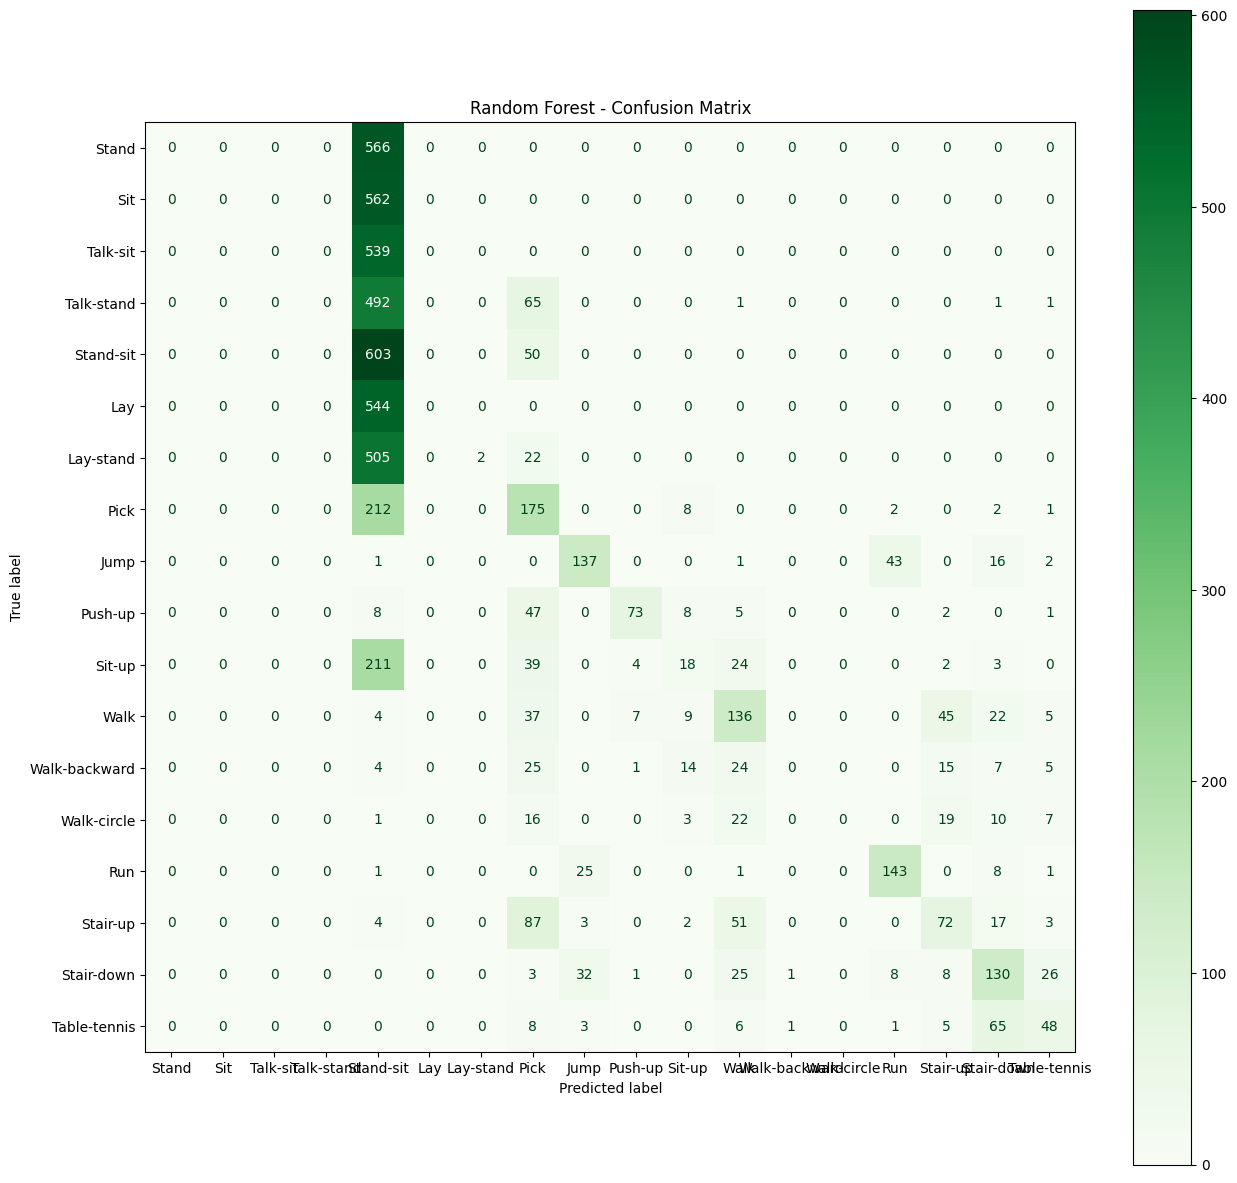

Model: KNN With PCA
Accuracy: 0.2231

               precision    recall  f1-score   support

        Stand       0.16      0.31      0.21       566
          Sit       0.16      0.23      0.19       562
     Talk-sit       0.16      0.19      0.17       539
   Talk-stand       0.41      0.51      0.45       560
    Stand-sit       0.23      0.28      0.25       653
          Lay       0.14      0.10      0.12       544
    Lay-stand       0.17      0.13      0.14       529
         Pick       0.18      0.12      0.15       400
         Jump       0.41      0.47      0.44       200
      Push-up       0.52      0.35      0.42       144
       Sit-up       0.24      0.16      0.19       301
         Walk       0.28      0.22      0.25       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.11      0.05      0.07        78
          Run       0.57      0.28      0.37       179
     Stair-up       0.20      0.07      0.10       239
   Stair-down       0.22  

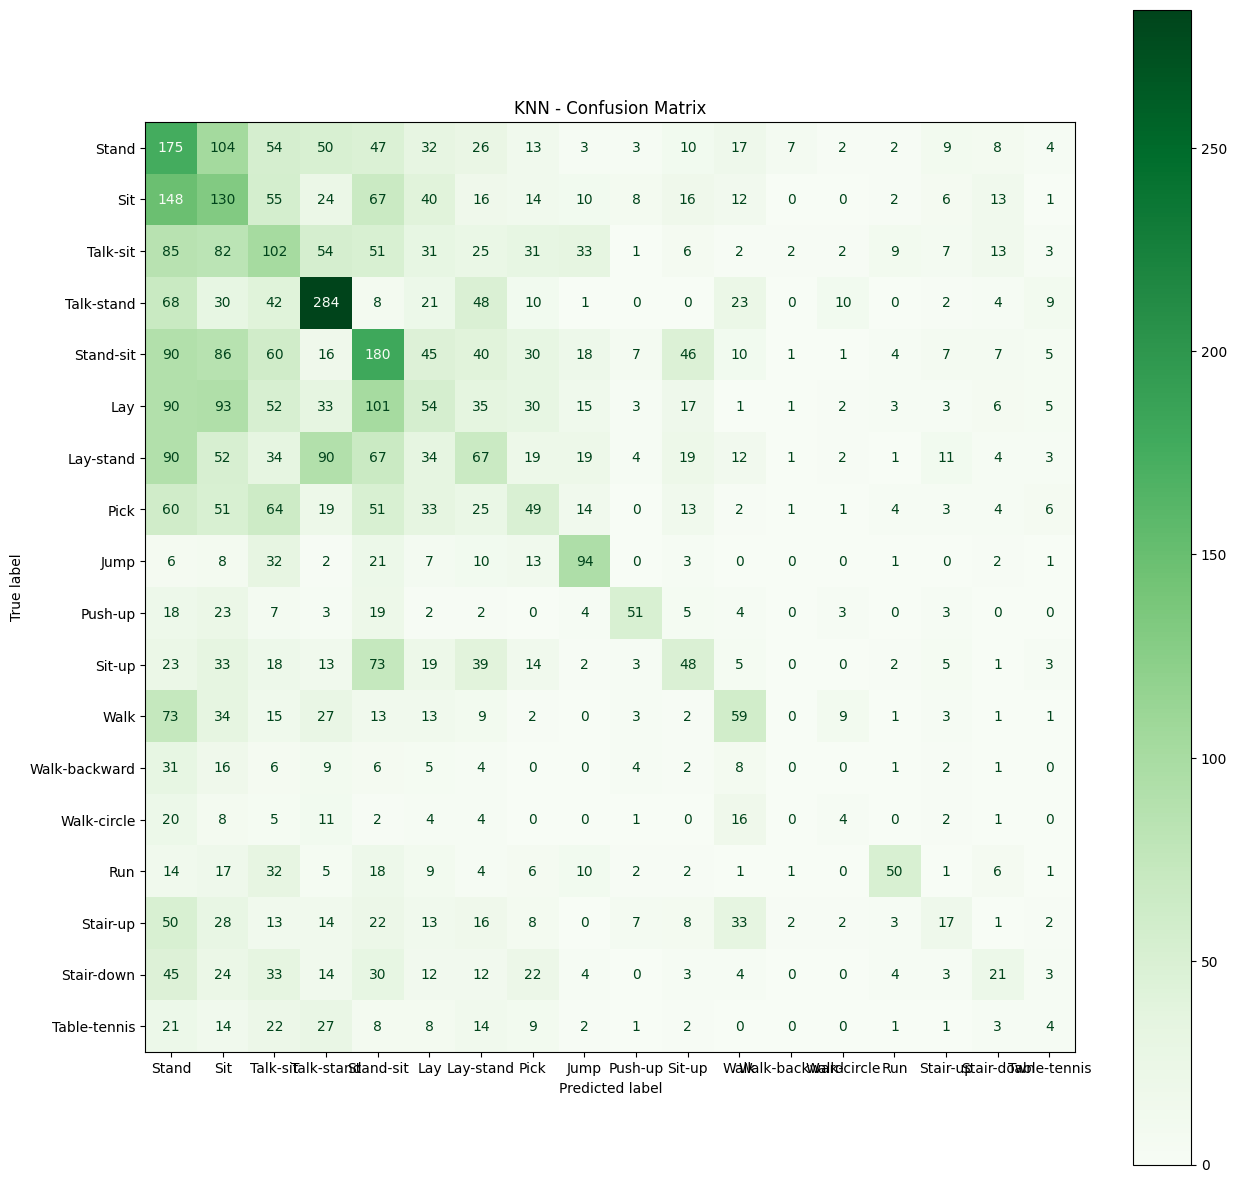

Model: XGBoost With PCA
Accuracy: 0.2476

               precision    recall  f1-score   support

        Stand       0.00      0.00      0.00       566
          Sit       0.00      0.00      0.00       562
     Talk-sit       0.00      0.00      0.00       539
   Talk-stand       0.00      0.00      0.00       560
    Stand-sit       0.14      0.92      0.25       653
          Lay       0.00      0.00      0.00       544
    Lay-stand       1.00      0.00      0.01       529
         Pick       0.30      0.44      0.36       400
         Jump       0.67      0.73      0.70       200
      Push-up       0.86      0.49      0.62       144
       Sit-up       0.28      0.06      0.10       301
         Walk       0.46      0.51      0.49       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       0.75      0.77      0.76       179
     Stair-up       0.43      0.30      0.35       239
   Stair-down       0.

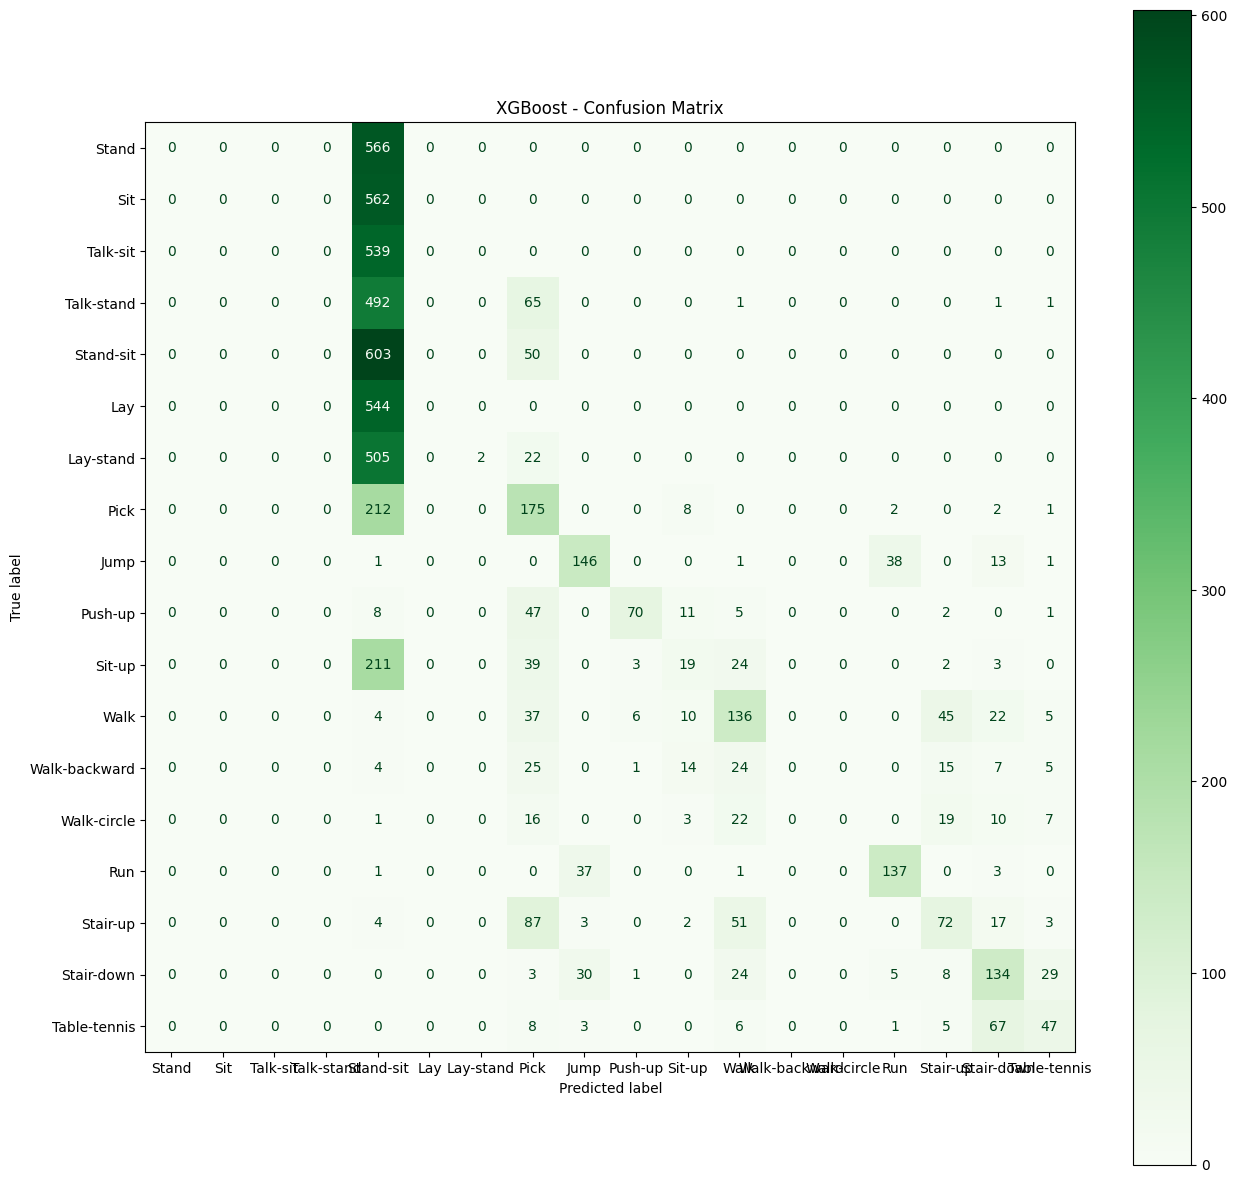

Model: MLP With PCA


c:\Users\aylin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5467

               precision    recall  f1-score   support

        Stand       0.45      0.35      0.39       566
          Sit       0.44      0.63      0.52       562
     Talk-sit       0.55      0.45      0.50       539
   Talk-stand       0.63      0.80      0.71       560
    Stand-sit       0.56      0.71      0.62       653
          Lay       0.60      0.60      0.60       544
    Lay-stand       0.54      0.44      0.48       529
         Pick       0.53      0.48      0.51       400
         Jump       0.85      0.90      0.88       200
      Push-up       0.52      0.44      0.48       144
       Sit-up       0.37      0.28      0.32       301
         Walk       0.50      0.72      0.59       265
Walk-backward       0.50      0.13      0.20        95
  Walk-circle       0.00      0.00      0.00        78
          Run       0.93      0.85      0.89       179
     Stair-up       0.37      0.26      0.31       239
   Stair-down       0.55      0.60      0.57  

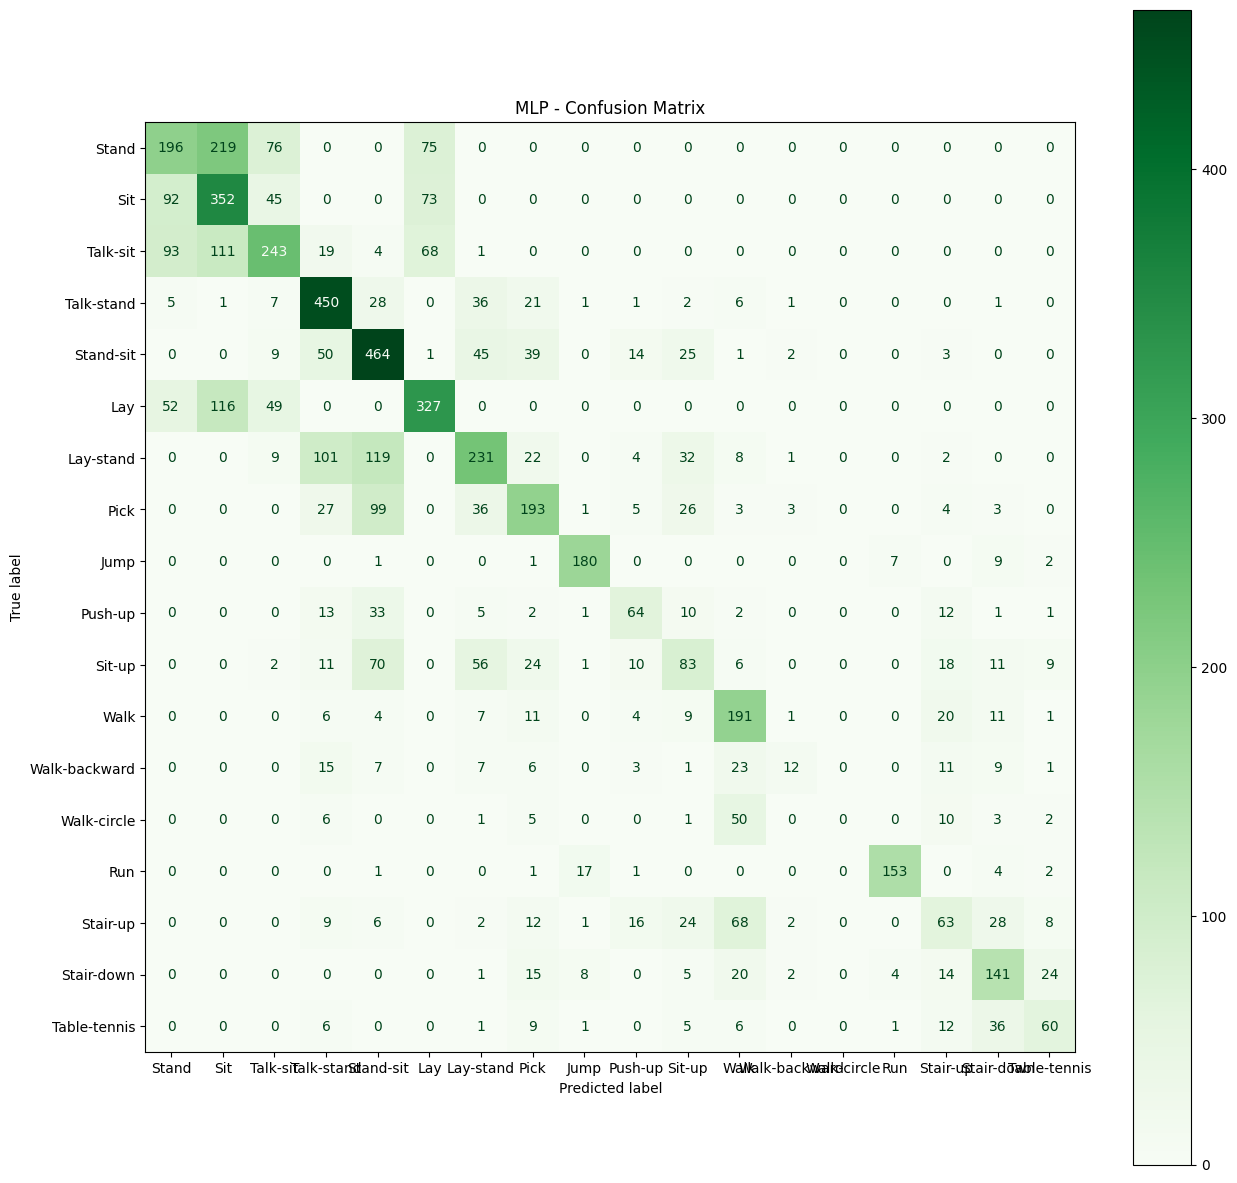

Model: Naive Bayes With PCA
Accuracy: 0.1099

               precision    recall  f1-score   support

        Stand       0.00      0.00      0.00       566
          Sit       0.00      0.00      0.00       562
     Talk-sit       0.00      0.00      0.00       539
   Talk-stand       0.00      0.00      0.00       560
    Stand-sit       0.11      1.00      0.19       653
          Lay       0.00      0.00      0.00       544
    Lay-stand       0.00      0.00      0.00       529
         Pick       0.00      0.00      0.00       400
         Jump       0.00      0.00      0.00       200
      Push-up       0.00      0.00      0.00       144
       Sit-up       0.00      0.00      0.00       301
         Walk       0.00      0.00      0.00       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       1.00      0.17      0.30       179
     Stair-up       0.00      0.00      0.00       239
   Stair-down     

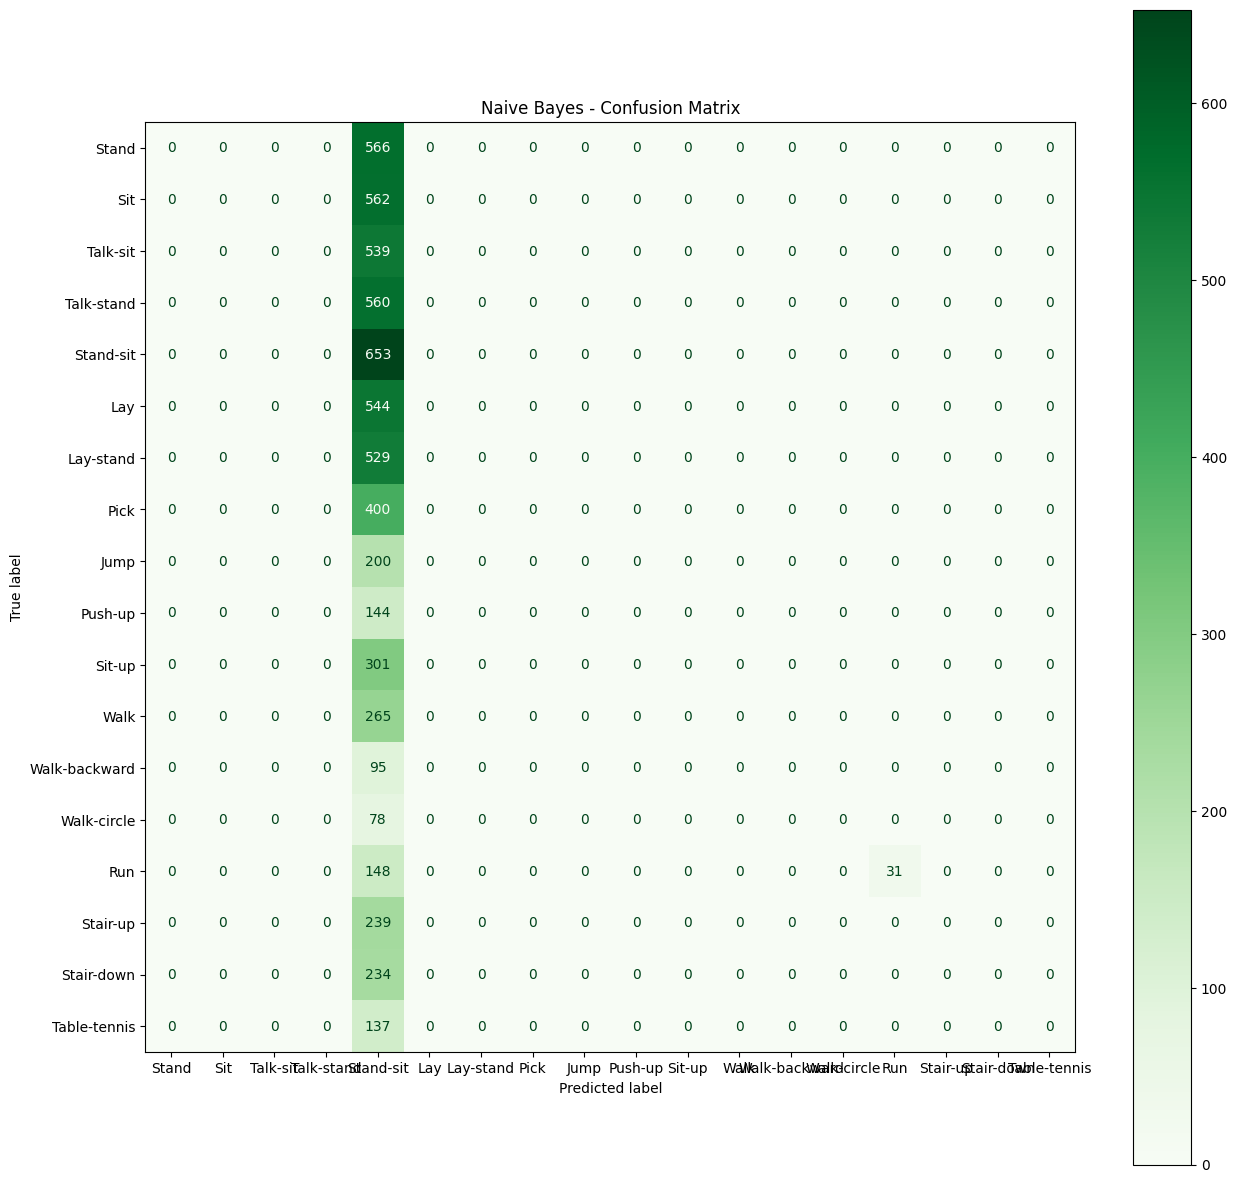

In [7]:
x_train_scaled_pca = pca.fit_transform(x_train_scaled)
x_test_scaled_pca = pca.transform(x_test_scaled)

joblib.dump(pca, 'models/kuhar/pca_transformer.joblib')

models_with_pca = [
    ("SVM", SVC(random_state=17), x_train_scaled_pca, x_test_scaled_pca),
    ("Random Forest", RandomForestClassifier(random_state=17),x_train_pca, x_test_pca ),
    ("KNN", KNeighborsClassifier(), x_train_scaled_pca, x_test_scaled_pca),
    ("XGBoost", XGBClassifier(verbosity=0, use_label_encoder=False,random_state=17),x_train_pca, x_test_pca),
    ("MLP", MLPClassifier(max_iter=300,random_state=17), x_train_scaled_pca, x_test_scaled_pca),
    ("Naive Bayes", GaussianNB(),x_train_pca, x_test_pca)
]

for name, model, xTrain, xTest in models_with_pca:
    model_train(model, xTrain, y_train, xTest, y_test, name, pca='With PCA')

HYPERPARAMETER OPTIMIZATION

---------SVM---------
Accuracy: 0.4275

               precision    recall  f1-score   support

        Stand       0.34      0.45      0.39       566
          Sit       0.38      0.41      0.40       562
     Talk-sit       0.37      0.38      0.37       539
   Talk-stand       0.49      0.73      0.58       560
    Stand-sit       0.38      0.66      0.49       653
          Lay       0.57      0.28      0.37       544
    Lay-stand       0.33      0.37      0.35       529
         Pick       0.39      0.23      0.29       400
         Jump       0.73      0.81      0.77       200
      Push-up       0.65      0.33      0.44       144
       Sit-up       0.35      0.19      0.24       301
         Walk       0.43      0.64      0.51       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       0.91      0.75      0.82       179
     Stair-up       0.32      0.10      0.15       239
   Stair-down       0.52

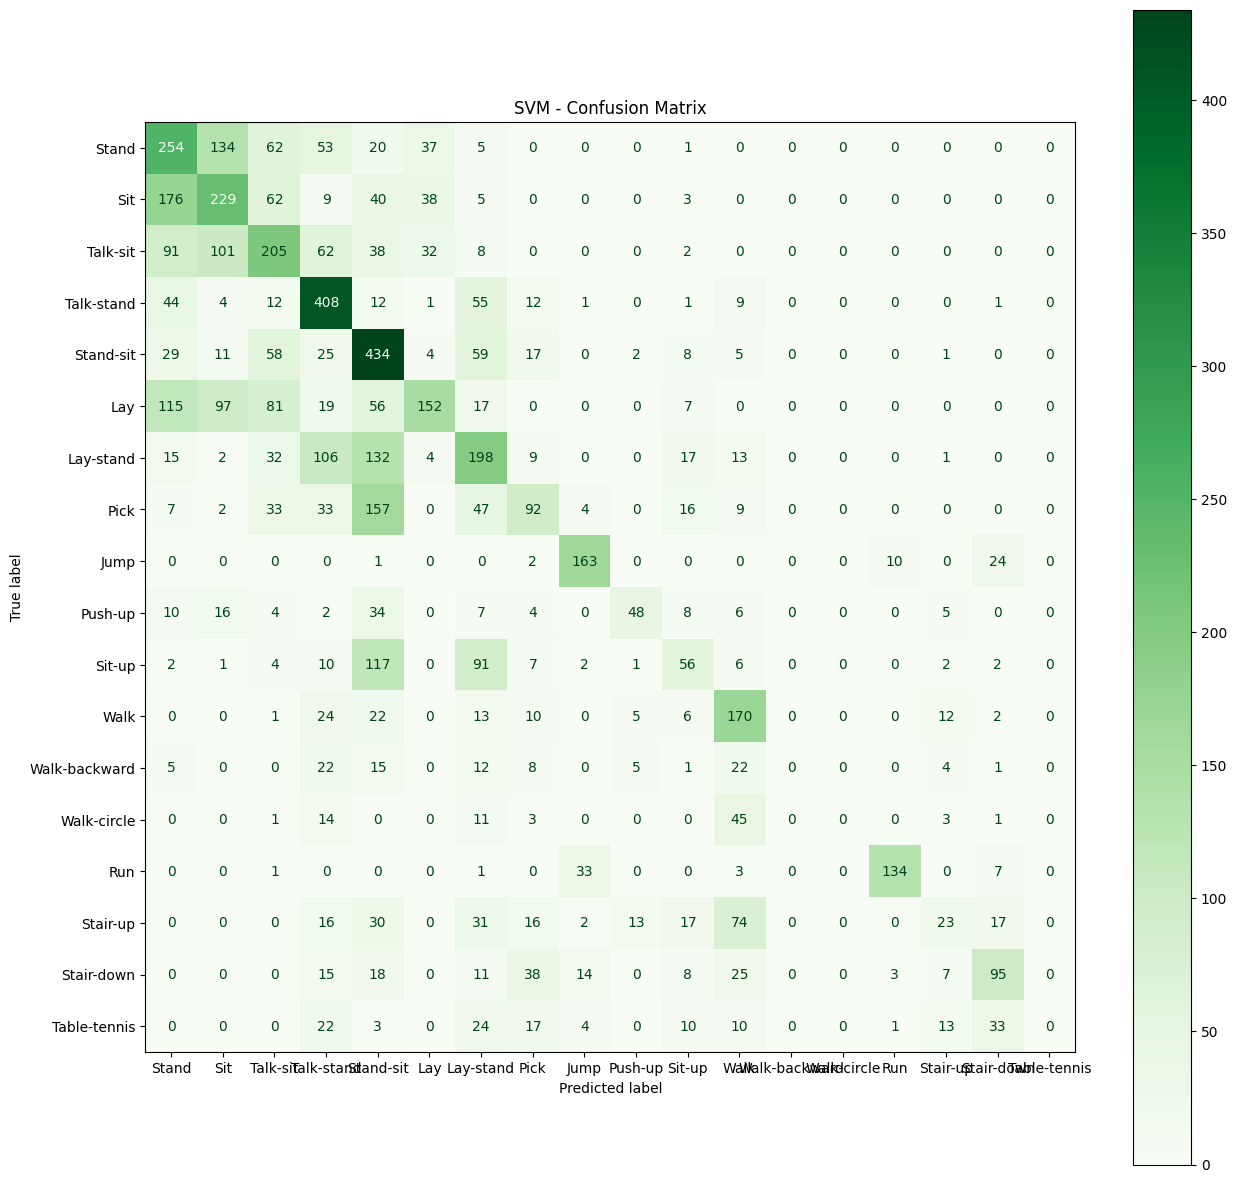


[SVM] Best F1-Score: 0.3685
[SVM] Best Parameters: (10, 'linear')

---------RF---------
Accuracy: 0.2506

               precision    recall  f1-score   support

        Stand       0.00      0.00      0.00       566
          Sit       0.00      0.00      0.00       562
     Talk-sit       0.00      0.00      0.00       539
   Talk-stand       0.00      0.00      0.00       560
    Stand-sit       0.14      0.92      0.25       653
          Lay       0.00      0.00      0.00       544
    Lay-stand       1.00      0.00      0.01       529
         Pick       0.30      0.44      0.36       400
         Jump       0.70      0.74      0.72       200
      Push-up       0.85      0.51      0.63       144
       Sit-up       0.31      0.06      0.10       301
         Walk       0.46      0.51      0.48       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       0.77      0.84      0.80       179
     Stair-u

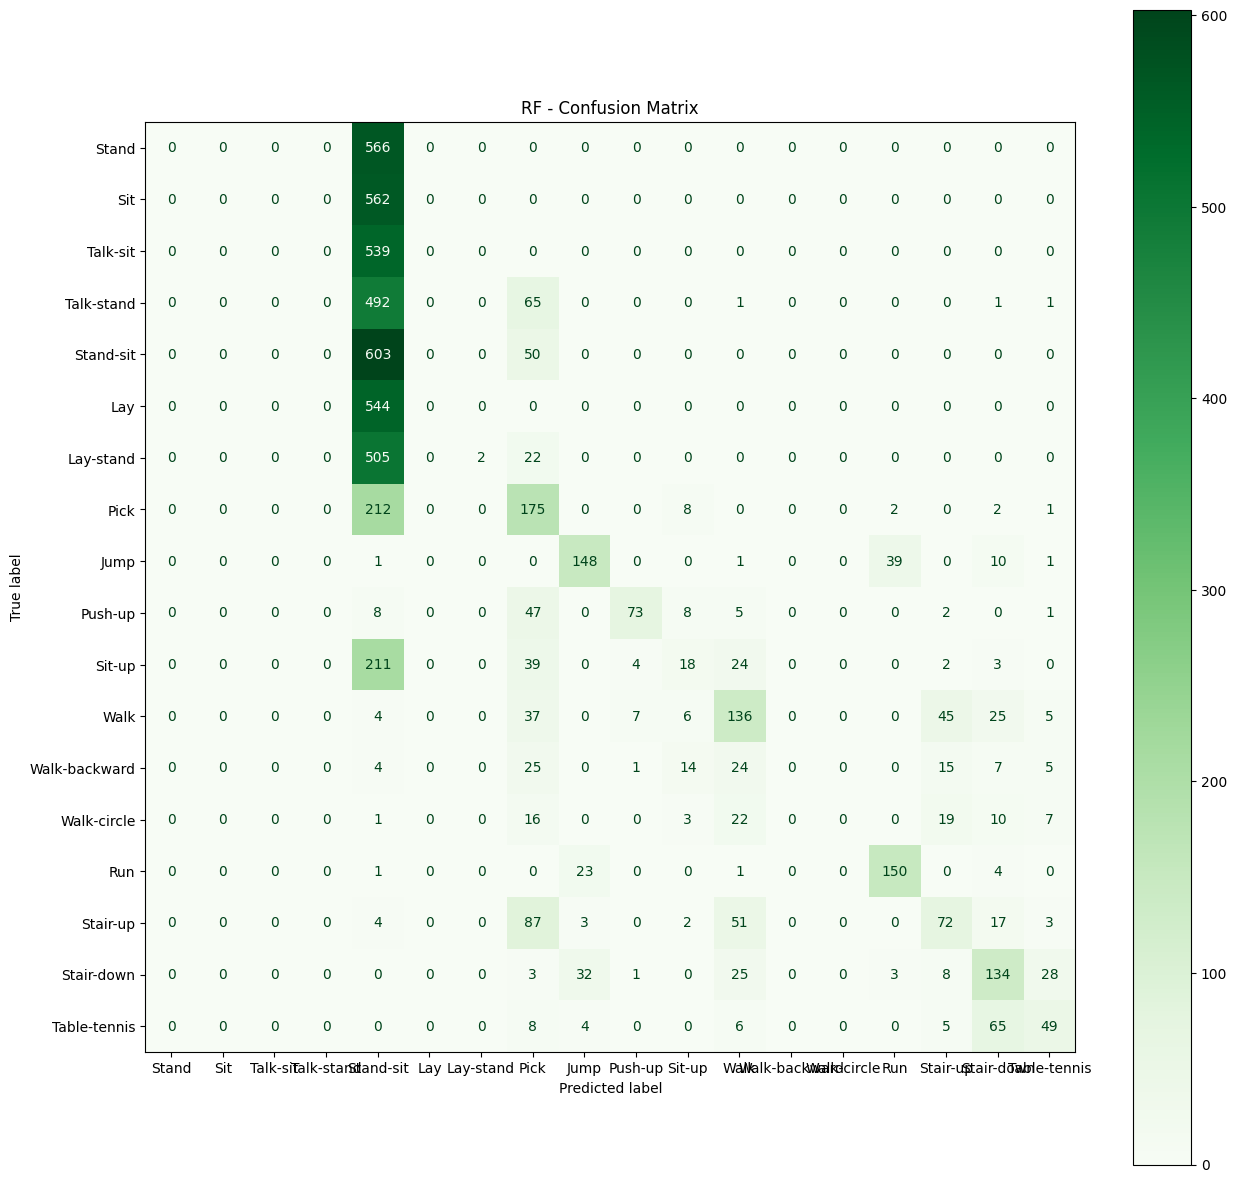


[RF] Best F1-Score: 0.2582
[RF] Best Parameters: (200, 10, 5)

---------KNN---------
Accuracy: 0.2427

               precision    recall  f1-score   support

        Stand       0.17      0.27      0.20       566
          Sit       0.18      0.25      0.21       562
     Talk-sit       0.17      0.19      0.18       539
   Talk-stand       0.43      0.57      0.49       560
    Stand-sit       0.23      0.33      0.27       653
          Lay       0.17      0.14      0.15       544
    Lay-stand       0.22      0.18      0.20       529
         Pick       0.18      0.14      0.16       400
         Jump       0.42      0.56      0.48       200
      Push-up       0.54      0.40      0.46       144
       Sit-up       0.21      0.14      0.17       301
         Walk       0.27      0.25      0.26       265
Walk-backward       0.07      0.01      0.02        95
  Walk-circle       0.18      0.08      0.11        78
          Run       0.65      0.27      0.39       179
     Stair-up  

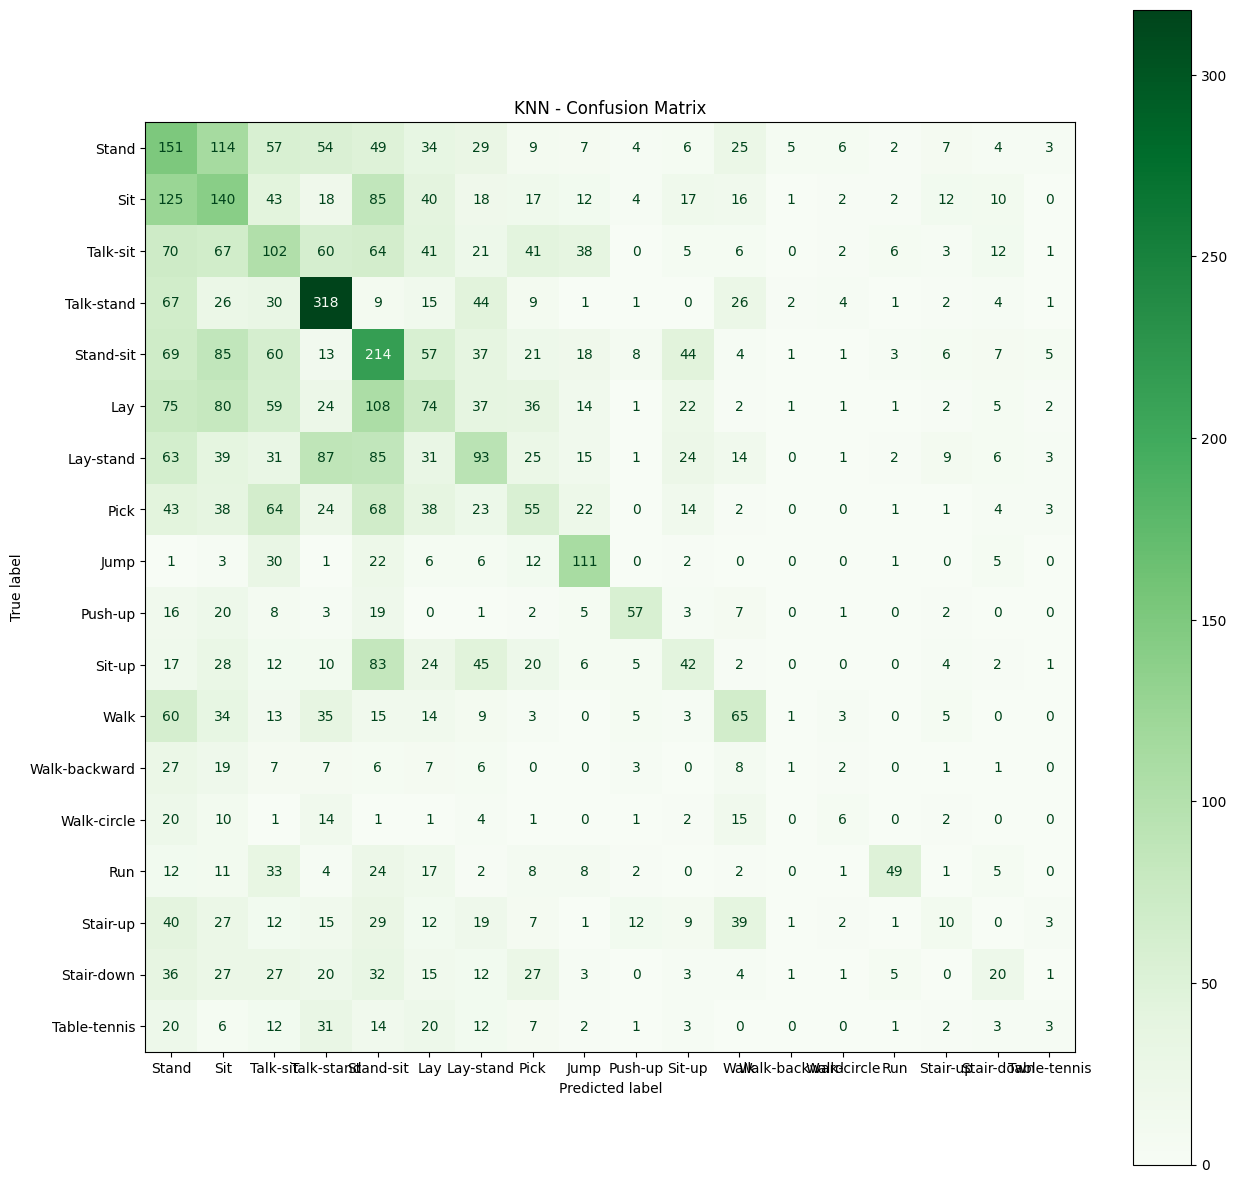


[KNN] Best F1-Score: 0.2200
[KNN] Best Parameters: 9

---------XGBoost---------
Accuracy: 0.2512

               precision    recall  f1-score   support

        Stand       0.00      0.00      0.00       566
          Sit       0.00      0.00      0.00       562
     Talk-sit       0.00      0.00      0.00       539
   Talk-stand       0.00      0.00      0.00       560
    Stand-sit       0.14      0.92      0.25       653
          Lay       0.00      0.00      0.00       544
    Lay-stand       1.00      0.00      0.01       529
         Pick       0.30      0.44      0.36       400
         Jump       0.68      0.72      0.70       200
      Push-up       0.86      0.51      0.64       144
       Sit-up       0.30      0.06      0.10       301
         Walk       0.52      0.41      0.46       265
Walk-backward       0.00      0.00      0.00        95
  Walk-circle       0.00      0.00      0.00        78
          Run       0.77      0.84      0.80       179
     Stair-up       

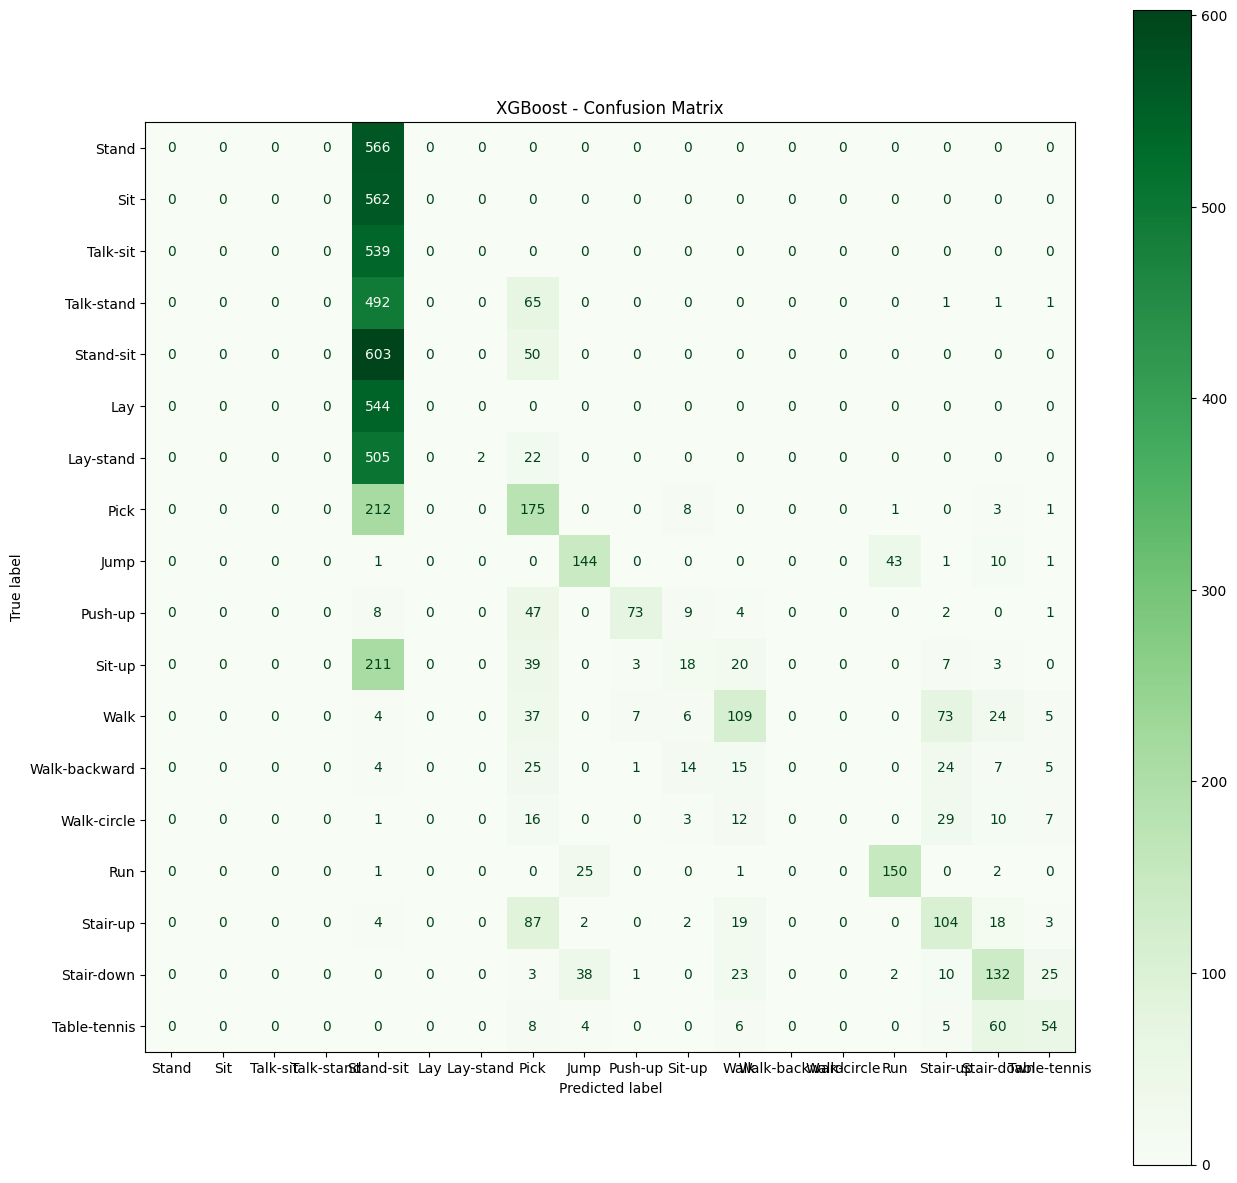


[XGBoost] Best F1-Score: 0.2612
[XGBoost] Best Parameters: (200, 3, 0.1)



c:\Users\aylin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aylin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aylin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aylin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the opti

---------MLP---------
Accuracy: 0.5875

               precision    recall  f1-score   support

        Stand       0.49      0.39      0.43       566
          Sit       0.46      0.65      0.54       562
     Talk-sit       0.63      0.52      0.57       539
   Talk-stand       0.72      0.75      0.74       560
    Stand-sit       0.59      0.75      0.66       653
          Lay       0.60      0.60      0.60       544
    Lay-stand       0.54      0.57      0.56       529
         Pick       0.59      0.59      0.59       400
         Jump       0.87      0.93      0.90       200
      Push-up       0.80      0.53      0.64       144
       Sit-up       0.47      0.26      0.33       301
         Walk       0.55      0.74      0.63       265
Walk-backward       0.34      0.17      0.23        95
  Walk-circle       0.15      0.04      0.06        78
          Run       0.98      0.87      0.92       179
     Stair-up       0.45      0.38      0.42       239
   Stair-down       0.56

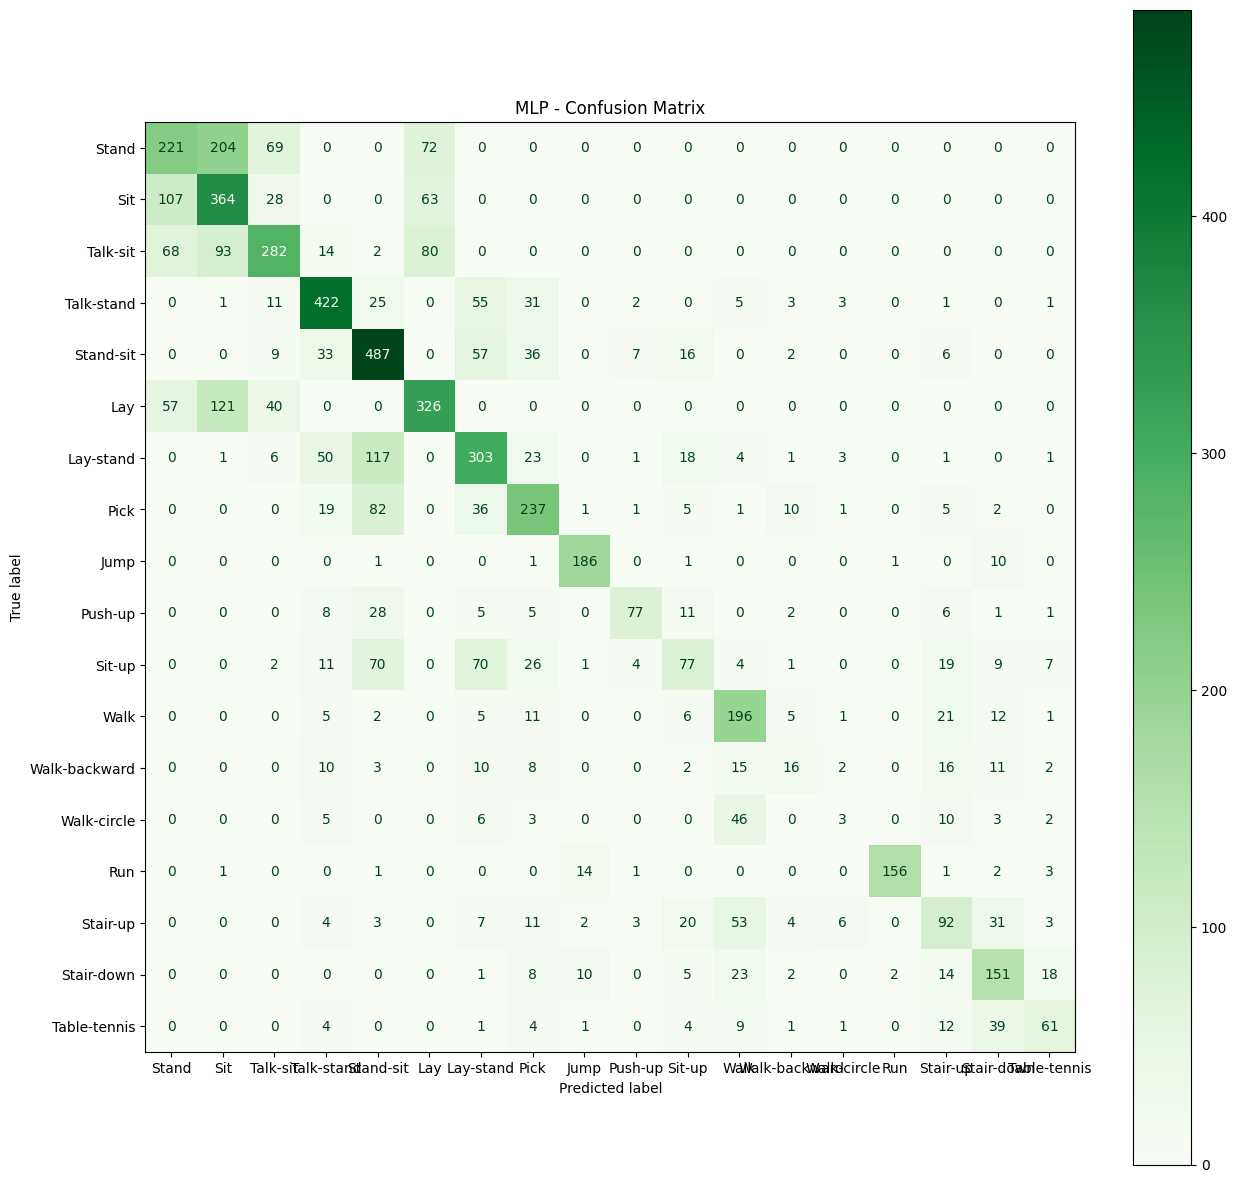


[MLP] Best F1-Score: 0.5517
[MLP] Best Parameters: ((64, 32), 'tanh')



In [8]:
best_param_SVM = None
best_param_RF = None
best_param_KNN = None
best_param_XGBoost = None
best_param_MLP = None

def SVM_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for C in [0.1, 1, 10]:
        for kernel in ['linear', 'rbf']:
            model = SVC(C=C, kernel=kernel , random_state=17)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            f1 = f1_score(y_test, y_pred, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_parameters = (C, kernel)
                best_model = model

    print("---------SVM---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(15,15))
            
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        best_y_pred,
        display_labels=activity_labels,
        cmap='Greens',  
        xticks_rotation='horizontal', 
        ax=ax 
    )
            
    plt.title('SVM - Confusion Matrix')
    plt.show()
    print(f"\n[SVM] Best F1-Score: {best_f1:.4f}")
    print("[SVM] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/kuhar/SVM_HP_optimization_kuhar.joblib')
    return best_parameters

def RF_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for n_estimators in [100, 200]:
        for max_depth in [None, 10, 20]:
            for min_samples_split in [2, 5]:
                model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=17)
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)

                f1 = f1_score(y_test, y_pred, average='macro')
                if f1 > best_f1:
                    best_f1 = f1
                    best_parameters = (n_estimators, max_depth, min_samples_split)
                    best_model = model

    print("---------RF---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(15,15))
            
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        best_y_pred,
        display_labels=activity_labels,
        cmap='Greens',  
        xticks_rotation='horizontal', 
        ax=ax 
    )
            
    plt.title('RF - Confusion Matrix')
    plt.show()
    print(f"\n[RF] Best F1-Score: {best_f1:.4f}")
    print("[RF] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/kuhar/RF_HP_optimization_kuhar.joblib')
    return best_parameters

def KNN_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for k in [3, 5, 7, 9]:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        f1 = f1_score(y_test, y_pred, average='macro')
            
        if f1 > best_f1:
            best_f1 = f1
            best_parameters = (k)
            best_model = model

    print("---------KNN---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(15,15))
            
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        best_y_pred,
        display_labels=activity_labels,
        cmap='Greens',  
        xticks_rotation='horizontal', 
        ax=ax 
    )
            
    plt.title('KNN - Confusion Matrix')
    plt.show()
    print(f"\n[KNN] Best F1-Score: {best_f1:.4f}")
    print("[KNN] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/kuhar/knn_HP_optimization_kuhar.joblib')
    return best_parameters

def XGBoost_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for n_estimators in [100, 200]:
        for max_depth in [3, 6, 10]:
            for learning_rate in [0.1, 0.3]:    
                model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbosity=0, use_label_encoder=False, random_state=17)
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
                
                f1 = f1_score(y_test, y_pred, average='macro')
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_parameters = (n_estimators, max_depth, learning_rate)
                    best_model = model

    
    print("---------XGBoost---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(15,15))
            
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        best_y_pred,
        display_labels=activity_labels,
        cmap='Greens',  
        xticks_rotation='horizontal', 
        ax=ax 
    )
            
    plt.title('XGBoost - Confusion Matrix')
    plt.show()
    print(f"\n[XGBoost] Best F1-Score: {best_f1:.4f}")
    print("[XGBoost] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/kuhar/XGBOOST_HP_optimization_kuhar.joblib')
    return best_parameters

def MLP_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for hl in [(50,), (100,), (64, 32)]:
        for activation in ['relu', 'tanh']:
            model = MLPClassifier(hidden_layer_sizes=hl, activation=activation, max_iter=300, random_state=17)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            f1 = f1_score(y_test, y_pred, average='macro')
            
            if f1 > best_f1:
                best_f1 = f1
                best_parameters = (hl, activation)
                best_model = model

    print("---------MLP---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(15,15))
            
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        best_y_pred,
        display_labels=activity_labels,
        cmap='Greens',  
        xticks_rotation='horizontal', 
        ax=ax 
    )
            
    plt.title('MLP - Confusion Matrix')
    plt.show()
    print(f"\n[MLP] Best F1-Score: {best_f1:.4f}")
    print("[MLP] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/kuhar/MLP_HP_optimization_kuhar.joblib')
    return best_parameters

best_param_SVM = SVM_optimization(x_train_scaled_pca,y_train,x_test_scaled_pca, y_test)
best_param_RF = RF_optimization(x_train_pca, y_train,x_test_pca, y_test)
best_param_KNN = KNN_optimization(x_train_scaled_pca,y_train,x_test_scaled_pca, y_test)
best_param_XGBoost = XGBoost_optimization(x_train_pca, y_train,x_test_pca, y_test)
best_param_MLP = MLP_optimization(x_train_scaled_pca,y_train,x_test_scaled_pca, y_test)